In [4]:
import matplotlib.pyplot as plt
from scipy.linalg import sqrtm, inv
import numpy as np
from tqdm import tqdm
import matplotlib.gridspec as gridspec

In [21]:
import matplotlib as mpl

mpl.rcParams.update({
    'font.family': 'Times New Roman',
    'font.size': 16,                # Default font size
    'axes.titlesize': 18,           # Title font size
    'axes.labelsize': 16,           # Axis label font size
    'xtick.labelsize': 16,
    'ytick.labelsize': 16,
    'legend.fontsize': 18,
    'figure.titlesize': 18,
    'lines.linewidth': 2,
    'lines.markersize': 8,
    'legend.frameon': False,
    'text.usetex': False            # Set to True if using LaTeX
})

Convergence % (move legend outside?)
Spec2, random, heavy tail

Plot number of iterations until convergence (examples where it does converge) (spec2 only)
x-axis: sample size, y-axis: iter until convergence (log scale) 

Convergence time plots
Figure 1: Theoretical (spec2 and random) + Slice at max sample size (show superlinear)
Figure 2: Faster less stable methods (spec2 and random)
Figure 3: Heavy tailed (3 methods under spec2)

Algorithms

In [5]:
# Take minimum error for all positive and negative x
def min_error(x_hat, x_star):
    errors = []
    for x in x_hat:
            error_positive = np.linalg.norm(x_star - x)
            error_negative = np.linalg.norm(-x_star - x)
            errors.append(min(error_positive, error_negative))
    return errors

In [40]:
def bwgd(y, A, niter=60, init="spec2"):
    d, n = A.shape
    x = np.zeros((niter, d))

    # Covariance matrix transform
    C = A @ A.T / n
    C_sqrt = sqrtm(C)
    C_inv = np.real(inv(C_sqrt))
    A_tilde = C_inv @ A

    # Initialization
    if init=="spec2":
        lambda_sq = (1 / n) * np.sum(y)
        lambda_val = np.sqrt(lambda_sq)
        Y = (1 / n) * (A_tilde @ np.diag((1/2 - np.exp(-y / lambda_sq)) ) @ A_tilde.T)
        eigenvals, eigenvects = np.linalg.eigh(Y)
        index = np.argmax(eigenvals)
        eigenvect = eigenvects[:, index]
        x_tilde = lambda_val * (eigenvect/ np.linalg.norm(eigenvect)) 
        x[0] = C_inv @ x_tilde
    
    elif init=="spec1":
        Y = (1 / n) * (A_tilde @ np.diag(y) @ A_tilde.T)
        eigenvals, eigenvects = np.linalg.eigh(Y)
        index = np.argmax(eigenvals)  
        x_tilde = np.sqrt(eigenvals[index] / 3) * eigenvects[:, index]
        x[0] = C_inv @ x_tilde
   
    elif init=="rand":
         x_tilde= np.random.randn(d)
         x[0] = C_inv @ x_tilde
           
    for iter in range(1, niter):
        hessian = (A_tilde @ A_tilde.T) / n
        
        # Gradient
        At_x = A_tilde.T @ x_tilde  
        gradient = hessian @ x_tilde - A_tilde @ (np.sqrt(y) * At_x / (np.abs(At_x)*n))
        x_tilde -= np.linalg.solve(hessian, gradient)

        x[iter] = C_inv @ x_tilde

        # Check for convergence
        if np.linalg.norm(x[iter] - x[iter - 1]) < 1e-10:
            return x[:iter], iter

    return x, iter

In [41]:
def bwgd_smooth(y, A, niter=60, gamma=0.01, init="spec2"):
    d, n = A.shape
    x = np.zeros((niter, d))

    # Covariance matrix transform
    C = A @ A.T / n
    C_sqrt = sqrtm(C)
    C_inv = np.real(inv(C_sqrt))
    A_tilde = C_inv @ A

     # Initialization
    if init=="spec2":
        lambda_sq = (1 / n) * np.sum(y**2)
        lambda_val = np.sqrt(lambda_sq)
        Y = (1 / n) * (A_tilde @ np.diag((1/np.sqrt(3) - np.exp(-y**2 / lambda_sq)) ) @ A_tilde.T)
        eigenvals, eigenvects = np.linalg.eigh(Y)
        index = np.argmax(eigenvals)
        eigenvect = eigenvects[:, index]
        x_tilde = lambda_val * (eigenvect/ np.linalg.norm(eigenvect)) 
        x[0] = C_inv @ x_tilde
    
    elif init=="spec1":
        Y = (1 / n) * (A_tilde @ np.diag(y) @ A_tilde.T)
        eigenvals, eigenvects = np.linalg.eigh(Y)
        index = np.argmax(eigenvals)  
        x_tilde = np.sqrt(eigenvals[index] / 3) * eigenvects[:, index]
        x[0] = C_inv @ x_tilde

    elif init=="rand":
         x_tilde= np.random.randn(d)
         x[0] = C_inv @ x_tilde


    for iter in range(1, niter):
        loss_values = (np.abs(A_tilde.T @ x_tilde) - y) ** 2
        epsilon = np.quantile(loss_values, gamma)

        # Compute values
        row_norms = np.sum(A_tilde**2, axis=0)
        numerator = np.sqrt(y**2 + epsilon * row_norms)
        denominator = np.sqrt(np.sum(A_tilde * ((np.outer(x_tilde,x_tilde) + epsilon * np.eye(d)) @ A_tilde), axis=0))
        alpha = numerator / denominator 

        # Update rule in matrix form
        x_tilde = (1/n) * A_tilde @ (alpha * (A_tilde.T @ x_tilde))
        
        x[iter] = C_inv @ x_tilde

        # Check for convergence
        if np.linalg.norm(x[iter] - x[iter - 1]) < 1e-10:
            return x[:iter], iter

    return x, iter

In [31]:
def bwgd_smooth_loss(y, A, niter=3000, init="spec2", step=True):
    d, n = A.shape
    x = np.zeros((niter, d))

    # Covariance matrix transform
    C = A @ A.T / n
    C_sqrt = sqrtm(C)
    C_inv = np.real(inv(C_sqrt))
    A_tilde = C_inv @ A

     # Initialization
    if init=="spec2":
        lambda_sq = (1 / n) * np.sum(y**2)
        lambda_val = np.sqrt(lambda_sq)
        Y = (1 / n) * (A_tilde @ np.diag((1/np.sqrt(3) - np.exp(-y**2 / lambda_sq)) ) @ A_tilde.T)
        eigenvals, eigenvects = np.linalg.eigh(Y)
        index = np.argmax(eigenvals)
        eigenvect = eigenvects[:, index]
        x_tilde = lambda_val * (eigenvect/ np.linalg.norm(eigenvect)) 
        x[0] = C_inv @ x_tilde
    
    elif init=="spec1":
        Y = (1 / n) * (A_tilde @ np.diag(y) @ A_tilde.T)
        eigenvals, eigenvects = np.linalg.eigh(Y)
        index = np.argmax(eigenvals)  
        x_tilde = np.sqrt(eigenvals[index] / 3) * eigenvects[:, index]
        x[0] = C_inv @ x_tilde

    elif init=="rand":
         x_tilde= np.random.randn(d)
         x[0] = C_inv @ x_tilde


    for iter in range(1, niter):
        loss_values = np.mean((np.abs(A_tilde.T @ x_tilde) - y) ** 2)
        epsilon = loss_values**(1/4)

        # step size
        if step:
            step = 1/(1 + epsilon)
        else:
            step = 1
        
        # Compute values
        row_norms = np.sum(A_tilde**2, axis=0)
        numerator = np.sqrt(y**2 + epsilon * row_norms)
        denominator = np.sqrt(np.sum(A_tilde * ((np.outer(x_tilde,x_tilde) + epsilon * np.eye(d)) @ A_tilde), axis=0))
        alpha = numerator / denominator 

        # Update rule in matrix form
        x_tilde = (1 - step) * x_tilde + step * (1/n) * A_tilde @ (alpha * (A_tilde.T @ x_tilde))
        
        x[iter] = C_inv @ x_tilde

        # Check for convergence
        if np.linalg.norm(x[iter] - x[iter - 1]) < 1e-10:
            return x[:iter], iter

    return x, iter

Spectral 2

In [30]:
# % of Convergence for higher samples, keeping d=200. Compares smooth and not smooth bwgd with the 2nd spectral initialization
d = 200
ns = np.linspace(400, 650, 10)
conv_regular = []
conv_smooth = []
conv_smoothl = []
iters = 30

for n in tqdm(ns):
    n=int(n)
    # Plot 
    conv_regular_number = 0
    conv_smooth_number = 0
    conv_smoothl_number = 0
    for j in range(iters):  
        # Generate vectors
        x = np.ones(d)/np.sqrt(d)
        A = np.random.randn(d, n)
        y1 = np.square(A.T @ x)
        y2 = np.abs(A.T @ x)
            
        # Run the algorithm
        x_hat1, iters1 = bwgd(y1, A, init="spec2")
        x_hat2, iters2 = bwgd_smooth(y2, A, init="spec2")
        x_hat3, iters3 = bwgd_smooth_loss(y2, A, init="spec2")

        if min_error(x_hat1, x)[-1]<1e-9:
            conv_regular_number += 1
        if min_error(x_hat2, x)[-1]<1e-9:
            conv_smooth_number += 1
        if min_error(x_hat3, x)[-1]<1e-9:
            conv_smoothl_number += 1
            
    conv_regular.append(conv_regular_number/iters)
    conv_smooth.append(conv_smooth_number/iters)
    conv_smoothl.append(conv_smoothl_number/iters)

100%|█████████████████████████████████████████████████████████████████████████████████| 10/10 [33:55<00:00, 203.55s/it]


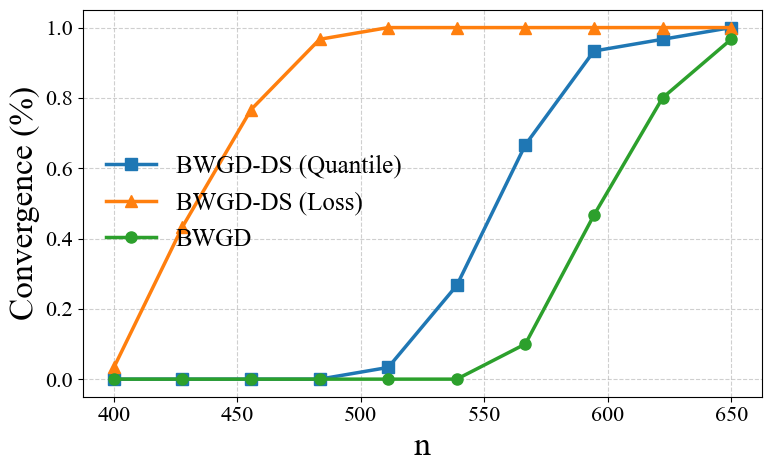

In [32]:
plt.figure(figsize=(8, 5))

# Plot with styling
plt.plot(ns, conv_smooth, label="BWGD-DS (Quantile)", linewidth=2.5, marker='s')
plt.plot(ns, conv_smoothl, label="BWGD-DS (Loss)", linewidth=2.5, marker='^')
plt.plot(ns, conv_regular, label="BWGD", linewidth=2.5, marker='o')


# Axis labels with font styling
plt.xlabel("Sample Size (n)", fontsize=24)
plt.ylabel("Convergence (%)", fontsize=24)

# Ticks and grid
plt.grid(True, linestyle='--', alpha=0.6)

plt.legend(loc='best', frameon=False)
plt.tight_layout()
plt.show()

In [43]:
def convergence_time(bwgd, init, samples, max_iter=60, step=True,  square=True,   num_trials = 50):
    d = 200                      
    
    # Initialize array: rows = iterations, cols = different sample sizes
    error_matrix = np.zeros((max_iter, len(samples)))
    
    for i, n in tqdm(enumerate(samples)):
        n = int(n)
        error_accumulator = np.zeros((max_iter,))
        converged_runs = 0
    
        for trial in range(num_trials):
            # Generate ground truth and data
            x = np.ones(d) / np.sqrt(d)
            A = np.random.randn(d, n)
            if square:
                y = np.square(A.T @ x)
            else:
                y = np.abs(A.T @ x)
    
            # Run the algorithm
            x_hat, iter_history = bwgd(y, A, init=init, niter=max_iter, step=step)
    
            # Compute errors at each iteration
            errors = min_error(x_hat, x)
            errors = np.array(errors)
            # Check for convergence
            if errors[-1] < 1e-8:
                # Pad with NaNs or extend with final error value
                if len(errors) < max_iter:
                    errors = np.concatenate([errors, np.full(max_iter - len(errors), errors[-1])])
                error_accumulator += errors[:max_iter]
                converged_runs += 1
    
        # Average over converged runs
        if converged_runs > 0:
            error_matrix[:, i] = error_accumulator / converged_runs
        else:
            error_matrix[:, i] = 0.5  # Mark as invalid if no convergence

    return error_matrix

In [56]:
def plot_convergence_time(error_matrices, max_iter, samples, size=(18, 5)):
    fig = plt.figure(figsize=size)
    gs = gridspec.GridSpec(1, 4, width_ratios=[1, 1, 1, 0.05])  # Last column for colorbar
    axs = [fig.add_subplot(gs[i]) for i in range(len(error_matrices))]

    for i, (ax, err_matrix) in enumerate(zip(axs, error_matrices)):
        im = ax.imshow(np.log10(err_matrix.T),  # Transpose for correct orientation
                       aspect='auto',
                       origin='lower',
                       extent=[0, max_iter, samples[0], samples[-1]],
                       cmap='viridis')
        
        if i == 0:
            ax.set_ylabel('Sample Size', fontsize=20)
        ax.tick_params(labelsize=12)

    # Shared x-axis label for the whole figure
    fig.text(0.5, 0.01, 'Iterations', ha='center', fontsize=24)

    # Colorbar
    cax = fig.add_subplot(gs[3])
    cbar = fig.colorbar(im, cax=cax)
    cbar.set_label('log10(Error)', fontsize=14)
    cbar.ax.tick_params(labelsize=12)

    plt.tight_layout(rect=[0, 0.05, 1, 1])  # Leave space at bottom for x-axis label
    plt.show()

def plot_convergence_time(mat1, mat2, max_iter, samples, size=(18, 5)):
    fig, axs = plt.subplots(1, 2, figsize=(12, 5), sharex=True, sharey=True, constrained_layout=True)
    
    # First plot
    im1 = axs[0].imshow(np.log10(mat1.T),
                        aspect='auto',
                        origin='lower',
                        extent=[0, max_iter, samples[0], samples[-1]],
                        cmap='viridis')    
    # Second plot
    im2 = axs[1].imshow(np.log10(mat2.T),
                        aspect='auto',
                        origin='lower',
                        extent=[0, max_iter, samples[0], samples[-1]],
                        cmap='viridis')
    
    # Shared colorbars on the right side
    cbar = fig.colorbar(im2, ax=axs, location='right', shrink=0.8)
    
    # Set common x and y labels
    fig.supxlabel('Iterations', fontsize=26)
    fig.supylabel('Sample size', fontsize=26)
    
    plt.show()

In [42]:
samples = np.linspace(450, 650, 11)
max_iter = 60                          
bs_spec2 = convergence_time(bwgd_smooth, init="spec2", samples=samples, max_iter=max_iter, square=False)
b_spec2 = convergence_time(bwgd, init="spec2", samples=samples, max_iter=max_iter, square=True)

11it [02:25, 13.18s/it]
11it [02:54, 15.83s/it]


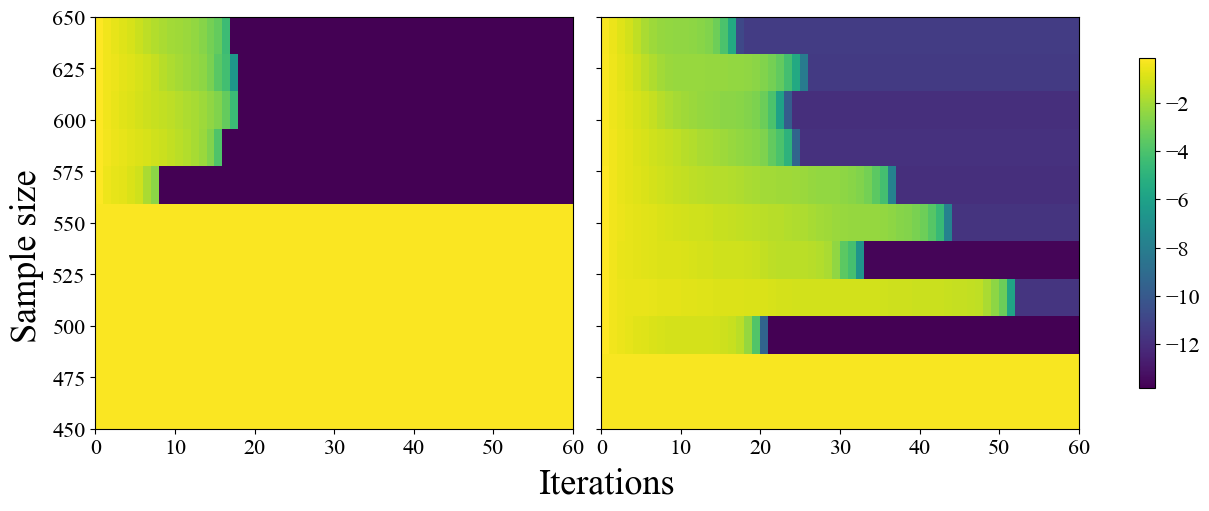

In [57]:
plot_convergence_time(b_spec2, bs_spec2, max_iter, samples)

In [62]:
samples = np.linspace(450, 650, 11)
max_iter = 2500   
bsl_spec2_step = convergence_time(bwgd_smooth_loss, init="spec2", samples=samples, max_iter=max_iter, square=False, num_trials = 10)
bsl_spec2 = convergence_time(bwgd_smooth_loss, init="spec2", samples=samples, max_iter=max_iter, square=False, step=False, num_trials = 10)

11it [10:22, 56.61s/it]
11it [12:48, 69.84s/it]


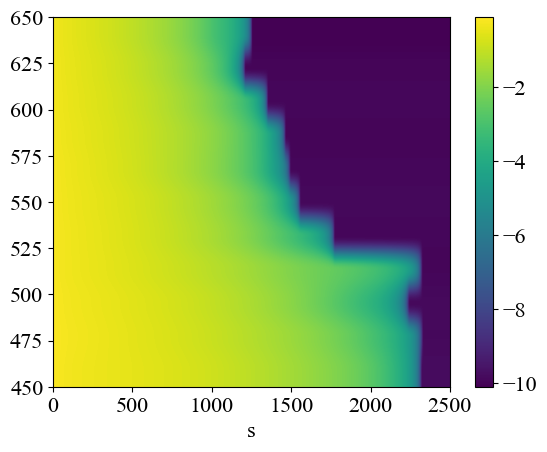

In [65]:
plt.imshow(np.log10(bsl_spec2_step.T),  # Transpose for correct orientation
                       aspect='auto',
                       origin='lower',
                       extent=[0, max_iter, samples[0], samples[-1]],
                       cmap='viridis')
plt.xlabel("Iterations")
plt.ylabel("Sample Size (n)")
plt.colorbar()
plt.show()

In [133]:
d=200
n=650
# Generate ground truth and data
x = np.ones(d) / np.sqrt(d)
A = np.random.randn(d, n)
y = np.abs(A.T @ x)
    
# Run the algorithm
x_hat, iter_history = bwgd_smooth_loss(y, A, init="spec2",niter=2000)
error = min_error(x_hat, x)

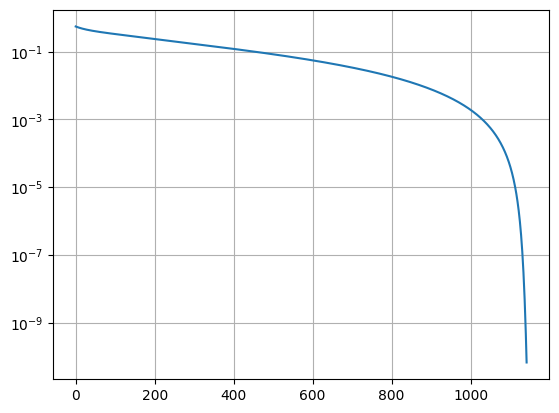

In [134]:
plt.plot(error)
plt.yscale('log')  
plt.grid(True)
plt.show()

Spectral 1

In [77]:
# % of Convergence for higher samples, keeping d=200. Compares smooth and not smooth bwgd with the 2nd spectral initialization
d = 200
ns = np.linspace(600, 850, 30)
conv_regular = []
conv_smooth = []
conv_smoothl = []
iters = 30

for n in tqdm(ns):
    n=int(n)
    # Plot 
    conv_regular_number = 0
    conv_smooth_number = 0
    conv_smoothl_number = 0
    for j in range(iters):  
        # Generate vectors
        x = np.ones(d)/np.sqrt(d)
        A = np.random.randn(d, n)
        y1 = np.square(A.T @ x)
        y2 = np.abs(A.T @ x)
            
        # Run the algorithm
        x_hat1, iters1 = bwgd(y1, A, init="spec1")
        x_hat2, iters2 = bwgd_smooth(y2, A, init="spec1")
        x_hat3, iters3 = bwgd_smooth_loss(y2, A, init="spec1")

        if min_error(x_hat1, x)[-1]<1e-9:
            conv_regular_number += 1
        if min_error(x_hat2, x)[-1]<1e-9:
            conv_smooth_number += 1
        if min_error(x_hat3, x)[-1]<1e-9:
            conv_smoothl_number += 1
            
    conv_regular.append(conv_regular_number/iters)
    conv_smooth.append(conv_smooth_number/iters)
    conv_smoothl.append(conv_smoothl_number/iters)

100%|██████████████████████████████████████████████████████████████████████████████████| 30/30 [13:35<00:00, 27.18s/it]


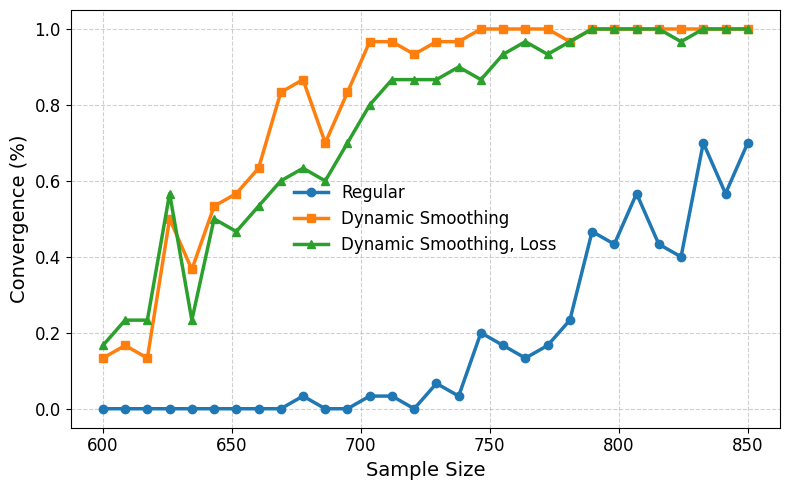

In [78]:
plt.figure(figsize=(8, 5))

# Plot with styling
plt.plot(ns, conv_regular, label="Regular", linewidth=2.5, marker='o')
plt.plot(ns, conv_smooth, label="Dynamic Smoothing", linewidth=2.5, marker='s')
plt.plot(ns, conv_smoothl, label="Dynamic Smoothing, Loss", linewidth=2.5, marker='^')

# Axis labels with font styling
plt.xlabel("n", fontsize=14)
plt.ylabel("Convergence (%)", fontsize=14)

# Ticks and grid
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
plt.grid(True, linestyle='--', alpha=0.6)

plt.legend(fontsize=12, loc='best', frameon=False)
plt.tight_layout()
plt.show()

In [62]:
#Convergence time
samples = np.linspace(650, 850, 41)
max_iter = 60                          
err_bsl_spec1 = convergence_time(bwgd_smooth_loss, init="spec1", samples=samples, max_iter=max_iter, square=False)
err_bs_spec1 = convergence_time(bwgd_smooth, init="spec1", samples=samples, max_iter=max_iter, square=False)
err_b_spec1 = convergence_time(bwgd, init="spec1", samples=samples, max_iter=max_iter, square=True)

41it [17:50, 26.12s/it]
41it [05:37,  8.23s/it]
41it [05:55,  8.68s/it]


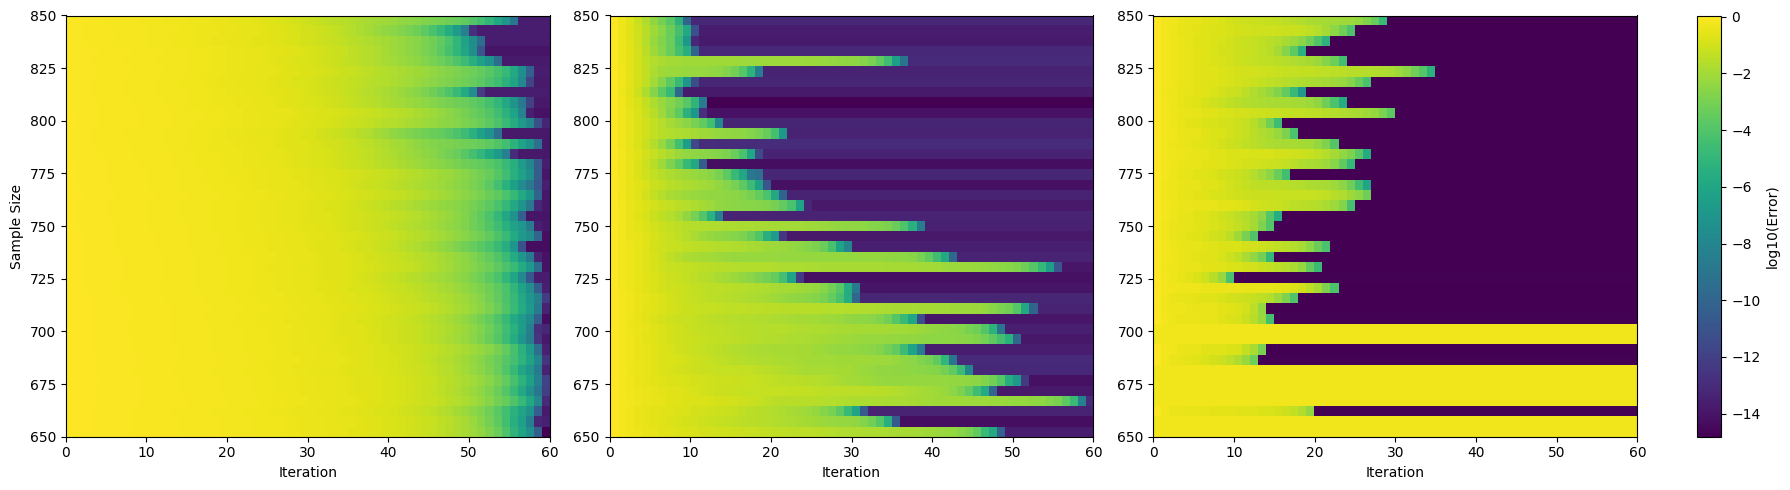

In [63]:
samples = np.linspace(650, 850, 41)
max_iter = 60 
errors_spec1 = [err_bsl_spec1, err_bs_spec1, err_b_spec1]
plot_convergence_time(errors_spec1, max_iter, samples)

Random

In [79]:
# % of Convergence for higher samples, keeping d=200. Compares smooth and not smooth bwgd with random init
d = 200
ns = np.linspace(2000, 2400, 30)
conv_regular = []
conv_smooth = []
conv_smoothl = []
iters = 30

for n in tqdm(ns):
    n=int(n)
    # Plot 
    conv_regular_number = 0
    conv_smooth_number = 0
    conv_smoothl_number = 0
    for j in range(iters):  
        # Generate vectors
        x = np.ones(d)/np.sqrt(d)
        A = np.random.randn(d, n)
        y1 = np.square(A.T @ x)
        y2 = np.abs(A.T @ x)
            
        # Run the algorithm
        x_hat1, iters1 = bwgd(y1, A, init="rand")
        x_hat2, iters2 = bwgd_smooth(y2, A, init="rand")
        x_hat3, iters3 = bwgd_smooth_loss(y2, A, init="rand")

        if min_error(x_hat1, x)[-1]<1e-9:
            conv_regular_number += 1
        if min_error(x_hat2, x)[-1]<1e-9:
            conv_smooth_number += 1
        if min_error(x_hat3, x)[-1]<1e-9:
            conv_smoothl_number += 1
            
    conv_regular.append(conv_regular_number/iters)
    conv_smooth.append(conv_smooth_number/iters)
    conv_smoothl.append(conv_smoothl_number/iters)

100%|██████████████████████████████████████████████████████████████████████████████████| 30/30 [21:11<00:00, 42.37s/it]


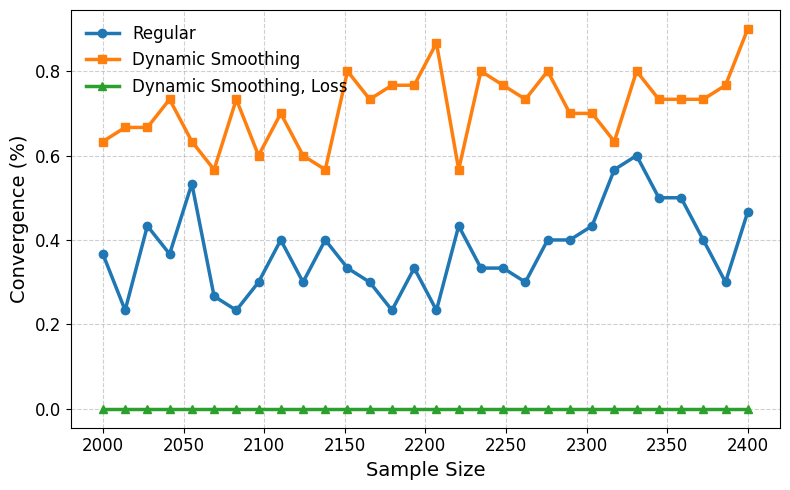

In [80]:
plt.figure(figsize=(8, 5))

# Plot with styling
plt.plot(ns, conv_regular, label="Regular", linewidth=2.5, marker='o')
plt.plot(ns, conv_smooth, label="Dynamic Smoothing", linewidth=2.5, marker='s')
plt.plot(ns, conv_smoothl, label="Dynamic Smoothing, Loss", linewidth=2.5, marker='^')

# Axis labels with font styling
plt.xlabel("n", fontsize=14)
plt.ylabel("Convergence (%)", fontsize=14)

# Ticks and grid
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
plt.grid(True, linestyle='--', alpha=0.6)

plt.legend(fontsize=12, loc='best', frameon=False)
plt.tight_layout()
plt.show()

In [64]:
# Convergence time
samples = np.linspace(2000, 2400, 41)
max_iter = 60                          
err_bs_rand = convergence_time(bwgd_smooth, init="rand", samples=samples, max_iter=max_iter, square=False)
err_b_rand = convergence_time(bwgd, init="rand", samples=samples, max_iter=max_iter, square=True)

41it [17:05, 25.01s/it]
41it [08:08, 11.92s/it]


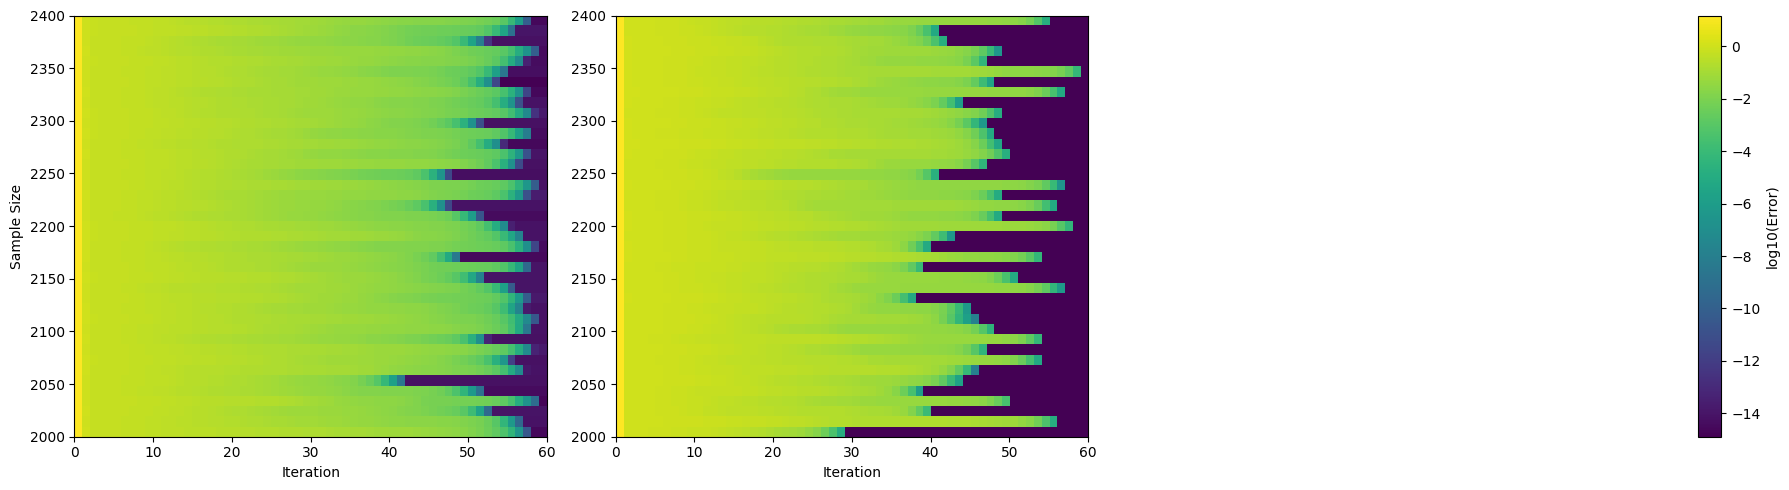

In [74]:
samples = np.linspace(2000, 2400, 41)
max_iter = 60   
errors_rand = [err_bs_rand, err_b_rand]
plot_convergence_time(errors_rand, max_iter, samples)

Dimension plot

100%|██████████████████████████████████████████████████████████████████████████████████| 15/15 [08:03<00:00, 32.20s/it]


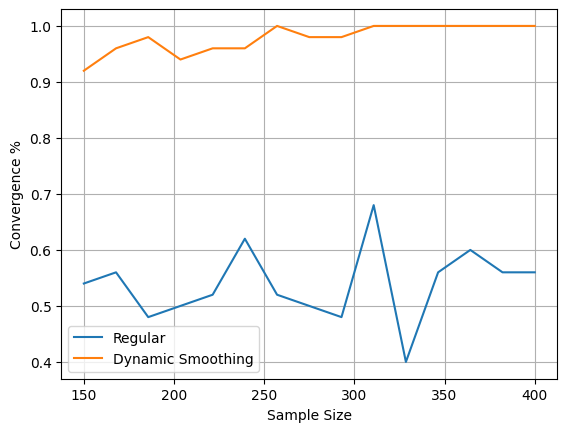

In [16]:
# % of Convergence for higher dimensions with n = dlog(d). Compares smooth and not smooth bwgd with the 2nd spectral initialization
ds = np.linspace(150, 400, 15)
conv_regular = []
conv_smooth = []
iters = 50

for d in tqdm(ds):
    d=int(d)
    n=d*3
    # Plot 
    conv_regular_number = 0
    conv_smooth_number = 0
    
    error=[]
    for j in range(iters):  
        # Generate vectors
        x = np.ones(d)/np.sqrt(d)
        A = np.random.randn(d, n)
        y1 = np.square(A.T @ x)
        y2 = np.abs(A.T @ x)
            
        # Run the algorithm
        x_hat1, iters1 = bwgd(y1, A, init="spec2")
        x_hat2, iters2 = bwgd_smooth(y2, A, init="spec2")
    
        if min_error(x_hat1, x)[-1]<1e-9:
            conv_regular_number += 1
        if min_error(x_hat2, x)[-1]<1e-9:
            conv_smooth_number += 1
    conv_regular.append(conv_regular_number/iters)
    conv_smooth.append(conv_smooth_number/iters)

plt.plot(ds, conv_regular, label="Regular")
plt.plot(ds, conv_smooth, label="Dynamic Smoothing")
plt.xlabel("Dimension")
plt.ylabel("Convergence %")
plt.legend()
plt.grid(True)
plt.show()

Heavy Tailed

In [81]:
# % of Convergence for higher samples, keeping d=200. Compares smooth and not smooth bwgd with the 2nd spectral initialization
d = 200
ns = np.linspace(500, 700, 15)
conv_regular = []
conv_smooth = []
conv_smoothl = []
iters = 20

for n in tqdm(ns):
    n=int(n)
    # Plot 
    conv_regular_number = 0
    conv_smooth_number = 0
    conv_smoothl_number = 0
    for j in range(iters):  
        # Generate vectors
        x = np.ones(d)/np.sqrt(d)
        A = np.random.standard_t(5, (d, n))
        y1 = np.square(A.T @ x)
        y2 = np.abs(A.T @ x)
            
        # Run the algorithm
        x_hat1, iters1 = bwgd(y1, A, init="spec2")
        x_hat2, iters2 = bwgd_smooth(y2, A, init="spec2")
        x_hat3, iters3 = bwgd_smooth_loss(y2, A, init="spec2")

        if min_error(x_hat1, x)[-1]<1e-9:
            conv_regular_number += 1
        if min_error(x_hat2, x)[-1]<1e-9:
            conv_smooth_number += 1
        if min_error(x_hat3, x)[-1]<1e-9:
            conv_smoothl_number += 1
            
    conv_regular.append(conv_regular_number/iters)
    conv_smooth.append(conv_smooth_number/iters)
    conv_smoothl.append(conv_smoothl_number/iters)

100%|██████████████████████████████████████████████████████████████████████████████████| 15/15 [02:18<00:00,  9.23s/it]


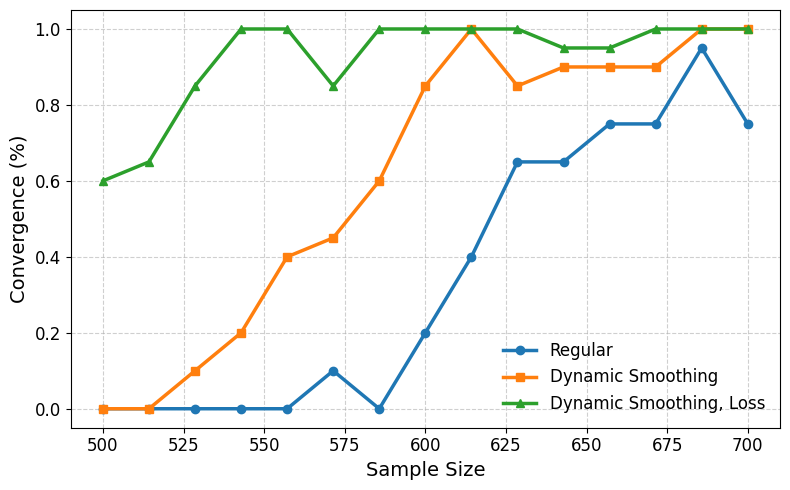

In [82]:
plt.figure(figsize=(8, 5))

# Plot with styling
plt.plot(ns, conv_regular, label="Regular", linewidth=2.5, marker='o')
plt.plot(ns, conv_smooth, label="Dynamic Smoothing", linewidth=2.5, marker='s')
plt.plot(ns, conv_smoothl, label="Dynamic Smoothing, Loss", linewidth=2.5, marker='^')

# Axis labels with font styling
plt.xlabel("n", fontsize=14)
plt.ylabel("Convergence (%)", fontsize=14)

# Ticks and grid
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
plt.grid(True, linestyle='--', alpha=0.6)

plt.legend(fontsize=12, loc='best', frameon=False)
plt.tight_layout()
plt.show()

In [40]:
def convergence_time_heavy_tail(bwgd, init, samples, max_iter=60,  square=True,   num_trials = 100):
    d = 200                      
    
    # Initialize array: rows = iterations, cols = different sample sizes
    error_matrix = np.zeros((max_iter, len(samples)))
    
    for i, n in tqdm(enumerate(samples)):
        n = int(n)
        error_accumulator = np.zeros((max_iter,))
        converged_runs = 0
    
        for trial in range(num_trials):
            # Generate ground truth and data
            x = np.ones(d) / np.sqrt(d)
            A = np.random.standard_t(5, (d, n))
            if square:
                y = np.square(A.T @ x)
            else:
                y = np.abs(A.T @ x)
    
            # Run the algorithm
            x_hat, iter_history = bwgd(y, A, init=init, niter=max_iter)
    
            # Compute errors at each iteration
            errors = min_error(x_hat, x)
            errors = np.array(errors)
            # Check for convergence
            if errors[-1] < 1e-8:
                # Pad with NaNs or extend with final error value
                if len(errors) < max_iter:
                    errors = np.concatenate([errors, np.full(max_iter - len(errors), errors[-1])])
                error_accumulator += errors[:max_iter]
                converged_runs += 1
    
        # Average over converged runs
        if converged_runs > 0:
            error_matrix[:, i] = error_accumulator / converged_runs
        else:
            error_matrix[:, i] = 0.5  # Mark as invalid if no convergence

    return error_matrix

In [66]:
#Convergence time
samples = np.linspace(550, 700, 21)
max_iter = 60                          
errh_bsl = convergence_time_heavy_tail(bwgd_smooth_loss, init="spec2", samples=samples, max_iter=max_iter, square=False)
errh_bs = convergence_time_heavy_tail(bwgd_smooth, init="spec2", samples=samples, max_iter=max_iter, square=False)
errh_b = convergence_time_heavy_tail(bwgd, init="spec2", samples=samples, max_iter=max_iter, square=True)

21it [03:31, 10.08s/it]
21it [02:38,  7.54s/it]
21it [02:27,  7.01s/it]


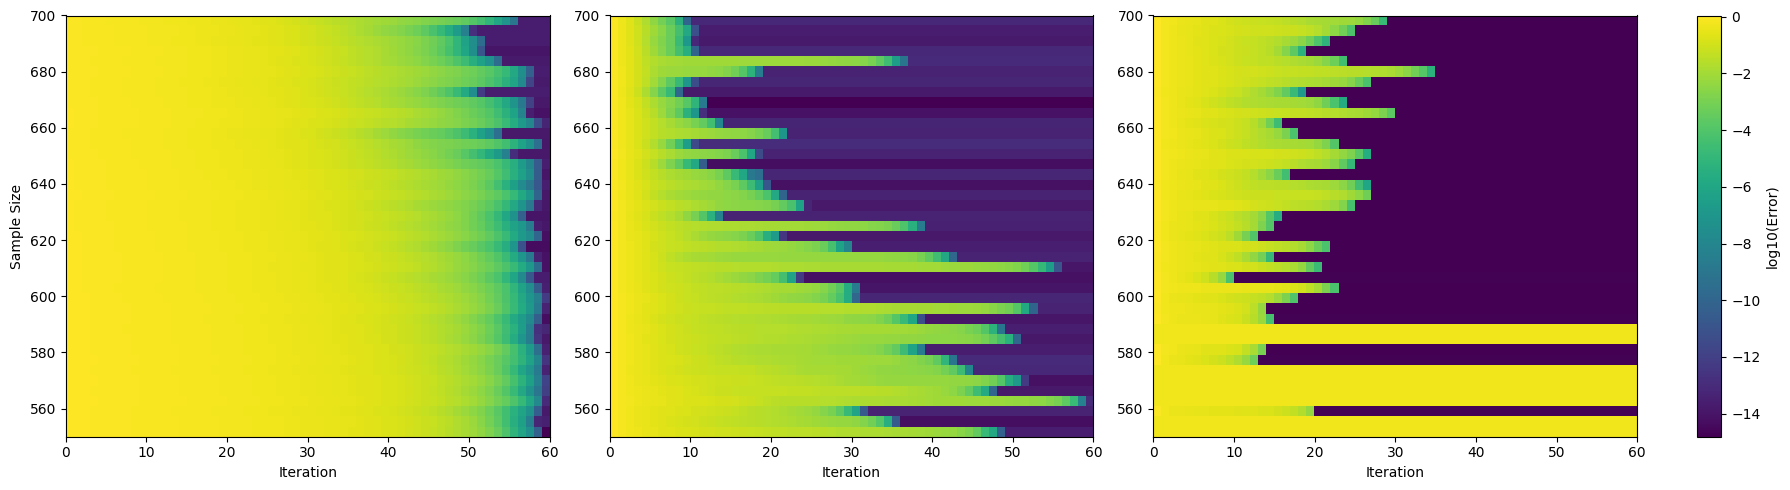

In [67]:
# DO 650 TO 450 (INCREASE ITERATIONS AND REPETITIONS)

samples = np.linspace(550, 700, 41)
max_iter = 60 
errorsh = [errh_bsl, errh_bs, errh_b]
plot_convergence_time(errors_spec1, max_iter, samples)